In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from glob import glob
from datetime import date
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('fivethirtyeight')

import matplotlib as mpl

from utils import *

today=date.today().strftime("%Y%m%d")

seed=38

%matplotlib inline
print(tf.__version__)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


2.9.1


In [2]:
#sorted(plt.style.available)

In [3]:
files = glob('/data/elekin/data/results/fmri/preproc/cbl/*/cbl_extracted_ts_{}.csv'.format(today))
data = []
for file in files:
    df = pd.read_csv(file, header=None)
    data.append(df.values.flatten())
features = np.array(data)
features.shape

(105, 4424)

In [4]:
levels = pd.read_csv('/data/elekin/data/results/fmri/preproc/cbl/cbl_levels_{}.csv'.format(today),index_col=0)
levels.sample(5)

,Level,Level3
T040,17.0,13.0
C132,0.0,11.0
C266,0.0,11.0
T030,22.0,13.0
C102,0.0,11.0


In [5]:
labels = (levels.Level > 0).astype(np.int16)
labels.sample(5)

T056    1
T025    1
C196    0
T001    1
T004    1
Name: Level, dtype: int16

Load fmri extracted raw time series from cerebellum atlas

Data is already scaled from preprocessing. Since the dataset is prettry small Hold-out technique is used to evaluate the FCNN

In [6]:
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.33)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70, 4424), (70,), (35, 4424), (35,))

When training a model, it is often recommended to lower the learning rate as the training progresses. This schedule applies the inverse decay function to an optimizer step, given a provided initial learning rate. It requires a step value to compute the decayed learning rate. You can just pass a TensorFlow variable that you increment at each training step.

The schedule a 1-arg callable that produces a decayed learning rate when passed the current optimizer step. This can be useful for changing the learning rate value across different invocations of optimizer functions. It is computed as:
```python
def decayed_learning_rate(step):
  return initial_learning_rate / (1 + decay_rate * step / decay_step)
```

In [8]:
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/InverseTimeDecay
STEPS_PER_EPOCH = 1
FEATURES = features.shape[1]

#to lower the learning rate as the training progresses
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

#seting up optimizer
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

### Callbacks
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
        

In [9]:
#Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=0.0001,
  patience=200)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=300),
      ]

def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy'])
    model.summary()
    history = model.fit(X_train, y_train, batch_size=16, use_multiprocessing=True, 
                            validation_data=(X_test,y_test), epochs=max_epochs, callbacks=get_callbacks(name),
                            verbose=1)
    return history

In [10]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [11]:
size_histories = {}

In [12]:
size_histories['fcnn/tiny'] = compile_and_fit(tiny, "fmri/fcnn/tiny", optimizer=None, max_epochs=1000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                70800     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 70,817
Trainable params: 70,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/5 [==============================] - 1s 30ms/step - loss: 0.6890 - accuracy: 0.4857 - binary_crossentropy: 0.6890 - val_loss: 0.6948 - val_accuracy: 0.5429 - val_binary_crossentropy: 0.6948
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6351 - accuracy: 0.8143 - binary_crossentropy: 0.6351 - val_loss: 0.6947 - val_accuracy: 0.4286 - val_binary_crossentropy: 0.6947
Epoch 3/1000
5/5 [=====================

Epoch 38/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0717 - accuracy: 1.0000 - binary_crossentropy: 0.0717 - val_loss: 0.7177 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.7177
Epoch 39/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0684 - accuracy: 1.0000 - binary_crossentropy: 0.0684 - val_loss: 0.7190 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.7190
Epoch 40/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0652 - accuracy: 1.0000 - binary_crossentropy: 0.0652 - val_loss: 0.7202 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.7202
Epoch 41/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0624 - accuracy: 1.0000 - binary_crossentropy: 0.0624 - val_loss: 0.7213 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.7213
Epoch 42/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0595 - accuracy: 1.0000 - binary_crossentropy: 0.0595 - val_loss: 0.7225 - val_accuracy: 0.5714 - val_bin

Epoch 78/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0179 - accuracy: 1.0000 - binary_crossentropy: 0.0179 - val_loss: 0.7672 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.7672
Epoch 79/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 1.0000 - binary_crossentropy: 0.0175 - val_loss: 0.7683 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.7683
Epoch 80/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 1.0000 - binary_crossentropy: 0.0171 - val_loss: 0.7694 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.7694
Epoch 81/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 1.0000 - binary_crossentropy: 0.0167 - val_loss: 0.7704 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.7704
Epoch 82/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0163 - accuracy: 1.0000 - binary_crossentropy: 0.0163 - val_loss: 0.7715 - val_accuracy: 0.5714 - val_bin

Epoch 118/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0082 - accuracy: 1.0000 - binary_crossentropy: 0.0082 - val_loss: 0.8044 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.8044
Epoch 119/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0081 - accuracy: 1.0000 - binary_crossentropy: 0.0081 - val_loss: 0.8051 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.8051
Epoch 120/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0080 - accuracy: 1.0000 - binary_crossentropy: 0.0080 - val_loss: 0.8058 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.8058
Epoch 121/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0079 - accuracy: 1.0000 - binary_crossentropy: 0.0079 - val_loss: 0.8066 - val_accuracy: 0.5714 - val_binary_crossentropy: 0.8066
Epoch 122/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0078 - accuracy: 1.0000 - binary_crossentropy: 0.0078 - val_loss: 0.8074 - val_accuracy: 0.5714 - va

Epoch 158/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0049 - accuracy: 1.0000 - binary_crossentropy: 0.0049 - val_loss: 0.8318 - val_accuracy: 0.5429 - val_binary_crossentropy: 0.8318
Epoch 159/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0048 - accuracy: 1.0000 - binary_crossentropy: 0.0048 - val_loss: 0.8324 - val_accuracy: 0.5429 - val_binary_crossentropy: 0.8324
Epoch 160/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0048 - accuracy: 1.0000 - binary_crossentropy: 0.0048 - val_loss: 0.8330 - val_accuracy: 0.5429 - val_binary_crossentropy: 0.8330
Epoch 161/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0047 - accuracy: 1.0000 - binary_crossentropy: 0.0047 - val_loss: 0.8335 - val_accuracy: 0.5429 - val_binary_crossentropy: 0.8335
Epoch 162/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0047 - accuracy: 1.0000 - binary_crossentropy: 0.0047 - val_loss: 0.8341 - val_accuracy: 0.5429 - va

Epoch 198/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - accuracy: 1.0000 - binary_crossentropy: 0.0033 - val_loss: 0.8536 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8536
Epoch 199/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - accuracy: 1.0000 - binary_crossentropy: 0.0033 - val_loss: 0.8541 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8541
Epoch 200/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - accuracy: 1.0000 - binary_crossentropy: 0.0033 - val_loss: 0.8545 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8545
Epoch 201/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 1.0000 - binary_crossentropy: 0.0032 - val_loss: 0.8549 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8549
Epoch 202/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 1.0000 - binary_crossentropy: 0.0032 - val_loss: 0.8554 - val_accuracy: 0.5143 - va

Epoch 238/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000 - binary_crossentropy: 0.0024 - val_loss: 0.8706 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8706
Epoch 239/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000 - binary_crossentropy: 0.0024 - val_loss: 0.8710 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8710
Epoch 240/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000 - binary_crossentropy: 0.0024 - val_loss: 0.8715 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8715
Epoch 241/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000 - binary_crossentropy: 0.0024 - val_loss: 0.8719 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8719
Epoch 242/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000 - binary_crossentropy: 0.0024 - val_loss: 0.8724 - val_accuracy: 0.5143 - va

Epoch 278/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 1.0000 - binary_crossentropy: 0.0019 - val_loss: 0.8858 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8858
Epoch 279/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 1.0000 - binary_crossentropy: 0.0019 - val_loss: 0.8861 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8861
Epoch 280/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 1.0000 - binary_crossentropy: 0.0018 - val_loss: 0.8865 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8865
Epoch 281/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 1.0000 - binary_crossentropy: 0.0018 - val_loss: 0.8868 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8868
Epoch 282/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 1.0000 - binary_crossentropy: 0.0018 - val_loss: 0.8872 - val_accuracy: 0.5143 - va

In [13]:
max(size_histories['fcnn/tiny'].history['accuracy']), max(size_histories['fcnn/tiny'].history['val_accuracy'])

(1.0, 0.6285714507102966)

In [14]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(FEATURES,)),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, 'fmri/fcnn/small')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                70800     
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 71,089
Trainable params: 71,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.6979 - accuracy: 0.4286 - binary_crossentropy: 0.6979 - val_loss: 0.6956 - val_accuracy: 0.4571 - val_binary_crossentropy: 0.6956
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.6578 - accuracy: 0.8571 - binary_cros

5/5 [==============================] - 0s 6ms/step - loss: 0.0215 - accuracy: 1.0000 - binary_crossentropy: 0.0215 - val_loss: 0.7962 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.7962
Epoch 38/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0198 - accuracy: 1.0000 - binary_crossentropy: 0.0198 - val_loss: 0.8002 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8002
Epoch 39/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 1.0000 - binary_crossentropy: 0.0184 - val_loss: 0.8045 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8045
Epoch 40/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 1.0000 - binary_crossentropy: 0.0171 - val_loss: 0.8085 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.8085
Epoch 41/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0160 - accuracy: 1.0000 - binary_crossentropy: 0.0160 - val_loss: 0.8125 - val_accuracy: 0.5143 - val_binary_crossentro

5/5 [==============================] - 0s 6ms/step - loss: 0.0034 - accuracy: 1.0000 - binary_crossentropy: 0.0034 - val_loss: 0.9077 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.9077
Epoch 78/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - accuracy: 1.0000 - binary_crossentropy: 0.0033 - val_loss: 0.9095 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.9095
Epoch 79/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0032 - accuracy: 1.0000 - binary_crossentropy: 0.0032 - val_loss: 0.9110 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.9110
Epoch 80/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 1.0000 - binary_crossentropy: 0.0031 - val_loss: 0.9128 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.9128
Epoch 81/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0031 - accuracy: 1.0000 - binary_crossentropy: 0.0031 - val_loss: 0.9145 - val_accuracy: 0.5143 - val_binary_crossentro

Epoch 117/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 1.0000 - binary_crossentropy: 0.0014 - val_loss: 0.9629 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.9629
Epoch 118/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 1.0000 - binary_crossentropy: 0.0014 - val_loss: 0.9640 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.9640
Epoch 119/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 1.0000 - binary_crossentropy: 0.0014 - val_loss: 0.9651 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.9651
Epoch 120/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 1.0000 - binary_crossentropy: 0.0014 - val_loss: 0.9662 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.9662
Epoch 121/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 1.0000 - binary_crossentropy: 0.0013 - val_loss: 0.9674 - val_accuracy: 0.5143 - va

5/5 [==============================] - 0s 5ms/step - loss: 8.3790e-04 - accuracy: 1.0000 - binary_crossentropy: 8.3790e-04 - val_loss: 0.9999 - val_accuracy: 0.5143 - val_binary_crossentropy: 0.9999
Epoch 157/1000
5/5 [==============================] - 0s 6ms/step - loss: 8.2799e-04 - accuracy: 1.0000 - binary_crossentropy: 8.2799e-04 - val_loss: 1.0007 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0007
Epoch 158/1000
5/5 [==============================] - 0s 6ms/step - loss: 8.1876e-04 - accuracy: 1.0000 - binary_crossentropy: 8.1876e-04 - val_loss: 1.0015 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0015
Epoch 159/1000
5/5 [==============================] - 0s 6ms/step - loss: 8.0948e-04 - accuracy: 1.0000 - binary_crossentropy: 8.0948e-04 - val_loss: 1.0022 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0022
Epoch 160/1000
5/5 [==============================] - 0s 6ms/step - loss: 8.0093e-04 - accuracy: 1.0000 - binary_crossentropy: 8.0093e-04 - val_loss: 1.0030 - 

5/5 [==============================] - 0s 6ms/step - loss: 5.6556e-04 - accuracy: 1.0000 - binary_crossentropy: 5.6556e-04 - val_loss: 1.0272 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0272
Epoch 195/1000
5/5 [==============================] - 0s 6ms/step - loss: 5.6045e-04 - accuracy: 1.0000 - binary_crossentropy: 5.6045e-04 - val_loss: 1.0279 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0279
Epoch 196/1000
5/5 [==============================] - 0s 5ms/step - loss: 5.5543e-04 - accuracy: 1.0000 - binary_crossentropy: 5.5543e-04 - val_loss: 1.0285 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0285
Epoch 197/1000
5/5 [==============================] - 0s 6ms/step - loss: 5.5038e-04 - accuracy: 1.0000 - binary_crossentropy: 5.5038e-04 - val_loss: 1.0292 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0292
Epoch 198/1000
5/5 [==============================] - 0s 5ms/step - loss: 5.4539e-04 - accuracy: 1.0000 - binary_crossentropy: 5.4539e-04 - val_loss: 1.0298 - 

5/5 [==============================] - 0s 6ms/step - loss: 4.1132e-04 - accuracy: 1.0000 - binary_crossentropy: 4.1132e-04 - val_loss: 1.0496 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0496
Epoch 233/1000
5/5 [==============================] - 0s 6ms/step - loss: 4.0801e-04 - accuracy: 1.0000 - binary_crossentropy: 4.0801e-04 - val_loss: 1.0502 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0502
Epoch 234/1000
5/5 [==============================] - 0s 5ms/step - loss: 4.0495e-04 - accuracy: 1.0000 - binary_crossentropy: 4.0495e-04 - val_loss: 1.0507 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0507
Epoch 235/1000
5/5 [==============================] - 0s 6ms/step - loss: 4.0195e-04 - accuracy: 1.0000 - binary_crossentropy: 4.0195e-04 - val_loss: 1.0512 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0512
Epoch 236/1000
5/5 [==============================] - 0s 6ms/step - loss: 3.9883e-04 - accuracy: 1.0000 - binary_crossentropy: 3.9883e-04 - val_loss: 1.0518 - 

5/5 [==============================] - 0s 6ms/step - loss: 3.1501e-04 - accuracy: 1.0000 - binary_crossentropy: 3.1501e-04 - val_loss: 1.0688 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0688
Epoch 271/1000
5/5 [==============================] - 0s 6ms/step - loss: 3.1291e-04 - accuracy: 1.0000 - binary_crossentropy: 3.1291e-04 - val_loss: 1.0693 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0693
Epoch 272/1000
5/5 [==============================] - 0s 6ms/step - loss: 3.1086e-04 - accuracy: 1.0000 - binary_crossentropy: 3.1086e-04 - val_loss: 1.0697 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0697
Epoch 273/1000
5/5 [==============================] - 0s 6ms/step - loss: 3.0887e-04 - accuracy: 1.0000 - binary_crossentropy: 3.0887e-04 - val_loss: 1.0702 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0702
Epoch 274/1000
5/5 [==============================] - 0s 6ms/step - loss: 3.0686e-04 - accuracy: 1.0000 - binary_crossentropy: 3.0686e-04 - val_loss: 1.0707 - 

5/5 [==============================] - 0s 6ms/step - loss: 2.5060e-04 - accuracy: 1.0000 - binary_crossentropy: 2.5060e-04 - val_loss: 1.0856 - val_accuracy: 0.5143 - val_binary_crossentropy: 1.0856


In [15]:
max(size_histories['fcnn/small'].history['accuracy']), max(size_histories['fcnn/small'].history['val_accuracy'])

(1.0, 0.6000000238418579)

In [16]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(FEATURES,)),    
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, "fmri/fcnn/large")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2265600   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,054,081
Trainable params: 3,054,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5/5 [============================

5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 35/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 36/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 37/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 38/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_

5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 73/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 74/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 75/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 76/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_

5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 111/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 112/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 113/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 114/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - 

5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 149/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 150/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 151/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 152/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - 

5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 187/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 188/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 189/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 190/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - 

5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 225/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 226/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 227/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 228/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - 

5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 263/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 264/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 265/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 266/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - 

5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373
Epoch 301/1000
5/5 [==============================] - 0s 6ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - binary_crossentropy: 1.2673e-11 - val_loss: 6.6373 - val_accuracy: 0.5714 - val_binary_crossentropy: 6.6373


In [17]:
max(size_histories['fcnn/large'].history['accuracy']), max(size_histories['fcnn/large'].history['val_accuracy'])

(1.0, 0.6000000238418579)

ValueError: 'fcnn/tiny' is not a valid value for color

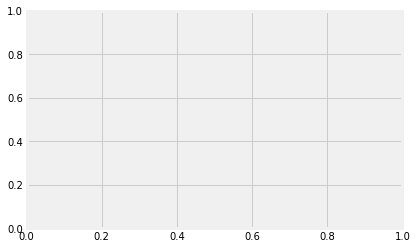

In [18]:
plot_report(size_histories)
_=plt.ylim([0., 1.05])

In [ ]:
plotter_acc = plot_report(size_histories, metric = 'loss')
_=plt.ylim([-0.05, 8.60])

In [ ]:
#shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
#shutil.copytree(logdir/'fmri/fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['tiny'] = size_histories['fcnn/tiny']

In [ ]:
lr = 8e-2
lr

In [ ]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dense(1, activation=tf.nn.sigmoid,kernel_regularizer=regularizers.l2(lr))
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

In [ ]:
plot_report(regularizer_histories)
_=plt.ylim([0., 1.05])

In [ ]:
plot_report(regularizer_histories, 'loss')
_=plt.ylim([-0.05, 1.50])

In [ ]:
dr=0.3
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
drop_model = tf.keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu,input_shape=(FEATURES,)),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(dr),
    layers.Dense(1, activation=tf.nn.sigmoid)
])

regularizer_histories['dropout'] = compile_and_fit(drop_model, "regularizers/dropout")

In [ ]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr),
                 input_shape=(FEATURES,)),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dropout(dr),
    layers.Dense(1, activation=tf.nn.sigmoid,
                 kernel_regularizer=regularizers.l2(lr))])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

In [ ]:
plot_report(regularizer_histories)
_=plt.ylim([0., 1.05])

In [ ]:
plot_report(regularizer_histories, 'loss')
plt.ylim([-0.05, 1.2])